In [314]:
import pandas as pd
import numpy as np
from basketball_reference_web_scraper import client
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from functools import reduce
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import shap

In [394]:
def split_scale_dataset(modelling_df):
    
    modelling_df = modelling_df.copy()
    seed = 23
    test_size = 0.1
    X_train, X_test, y_train, y_test = train_test_split(modelling_df.iloc[:,:-1], modelling_df.iloc[:,-1], test_size=test_size, random_state=seed)
    
    s_scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(s_scaler.transform(X_train))
    X_test_scaled = pd.DataFrame(s_scaler.transform(X_test))
    
    X_train_scaled.index = X_train.index 
    X_test_scaled.index = X_test.index
    
    cols = ['f' + str(x) for x in X_train_scaled.columns]
    X_train_scaled.columns = cols
    X_test_scaled.columns = cols
    
    return X_train_scaled,X_test_scaled,y_train,y_test

def grid_search_cv_model(X_train,y_train, model_type):
    
    X_train = X_train.copy()
    y_train = y_train.copy()
    
    if model_type == "Classifer":
        model = XGBClassifier()
        scoring = 'roc_auc'
    elif model_type == "Regressor":
        model = XGBRegressor()
        scoring = 'r2'
    else:
        raise Exception('Please enter a valid model type! (Classifer/Regressor)')

    param_grid = {
        'n_estimators': [1000,2000],
        'learning_rate': [0.01,0.001],
        'colsample_bytree':  [0.4,0.6,0.8],
        'max_depth': [3,4,5],
        'subsample': [0.8, 0.9],
        'gamma': [0,1,5]
        #'reg_alpha': [1.1, 1.3],
        #'reg_lambda': [1.1, 1.3],
    }
    

    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=5, 
        n_jobs=4, 
        scoring=scoring,
        verbose=2
    )

    model = gs.fit(X_train, y_train)
    
    return model

def get_testing_df(X_test,y_test,model):
    
    X_test = X_test.copy()
    y_test = y_test.copy()
    X_test_mod = X_test.copy()
    
    if type(X_test) != np.ndarray:
        X_test_mod.columns = model.best_estimator_.get_booster().feature_names
    
    preds = model.predict(X_test)
    testing_df = pd.DataFrame({'preds':preds,'actuals':y_test})
    
    return testing_df

def get_feature_imp_df(modelling_df,model):
    
    modelling_df = modelling_df.copy()
    
    feature_imp_df = pd.DataFrame({'Feature':modelling_df.iloc[:,:-1].columns,'Gain':model.best_estimator_.feature_importances_})
    feature_imp_df = feature_imp_df.sort_values(['Gain'],ascending=False)
    
    return feature_imp_df

def get_shap_imp_df(modelling_df,X_train,model):
    
    modelling_df = modelling_df.copy()
    X_train = X_train.copy()
    
    X_df = pd.DataFrame(X_train)
    X_df.columns = modelling_df.iloc[:,:-1].columns
    explainer = shap.TreeExplainer(model.best_estimator_)
    shap_values = explainer.shap_values(X_df)
    
    return shap_values, X_df

In [278]:
start_date = datetime(day=15,month=10,year=2018)
years = np.arange(2018,2021+1)
months = np.arange(1,12+1)
days = np.arange(1,31+1)

tbs_full_df =  pd.DataFrame(columns=['outcome', 'minutes_played', 'made_field_goals',
                                   'attempted_field_goals', 'made_three_point_field_goals',
                                   'attempted_three_point_field_goals', 'made_free_throws',
                                   'attempted_free_throws', 'offensive_rebounds', 'defensive_rebounds',
                                   'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls', 'points',
                                   'h_a', 'index_o', 'outcome_o', 'minutes_played_o', 'made_field_goals_o',
                                   'attempted_field_goals_o', 'made_three_point_field_goals_o',
                                   'attempted_three_point_field_goals_o', 'made_free_throws_o',
                                   'attempted_free_throws_o', 'offensive_rebounds_o',
                                   'defensive_rebounds_o', 'assists_o', 'steals_o', 'blocks_o',
                                   'turnovers_o', 'personal_fouls_o', 'points_o', 'h_a_o', 'date'])
for y in years:
    for m in months:
        for d in days:
            try:
                if datetime(day=d,month=m,year=y) > datetime.now() or datetime(day=d,month=m,year=y) < start_date:
                    continue
            except ValueError as v:
                    continue
                    
            tbs = client.team_box_scores(day=d, month=m, year=y)
            tbs_day_df = pd.DataFrame(columns=['outcome', 'minutes_played', 'made_field_goals',
                                               'attempted_field_goals', 'made_three_point_field_goals',
                                               'attempted_three_point_field_goals', 'made_free_throws',
                                               'attempted_free_throws', 'offensive_rebounds', 'defensive_rebounds',
                                               'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls', 'points'],dtype='float32')
            for bs in tbs:
                tbs_df = pd.DataFrame(bs,index=[bs['team']]).drop('team',axis=1)
                tbs_df['outcome'] = 1 if tbs_df['outcome'].values[0].value == "WIN" else 0
                tbs_day_df = tbs_day_df.append(tbs_df)
            
            tbs_day_df['h_a'] = [1 if i%2 == 1 else 0 for i in range(tbs_day_df.shape[0])]
            tbs_day_1_df = tbs_day_df.iloc[0::2].reset_index().join(tbs_day_df.iloc[1::2].reset_index(),rsuffix='_o')
            tbs_day_2_df = tbs_day_df.iloc[1::2].reset_index().join(tbs_day_df.iloc[0::2].reset_index(),rsuffix='_o')
            tbs_day_f_df = tbs_day_1_df.append(tbs_day_2_df).set_index('index')
            tbs_day_f_df['date'] = '%s-%s-%s'%(y,m,d)
            tbs_full_df = tbs_full_df.append(tbs_day_f_df)

            print("Finished getting matches for %s/%s/%s"%(y,m,d))

Finished getting matches for 2018/10/15
Finished getting matches for 2018/10/16
Finished getting matches for 2018/10/17
Finished getting matches for 2018/10/18
Finished getting matches for 2018/10/19
Finished getting matches for 2018/10/20
Finished getting matches for 2018/10/21
Finished getting matches for 2018/10/22
Finished getting matches for 2018/10/23
Finished getting matches for 2018/10/24
Finished getting matches for 2018/10/25
Finished getting matches for 2018/10/26
Finished getting matches for 2018/10/27
Finished getting matches for 2018/10/28
Finished getting matches for 2018/10/29
Finished getting matches for 2018/10/30
Finished getting matches for 2018/10/31
Finished getting matches for 2018/11/1
Finished getting matches for 2018/11/2
Finished getting matches for 2018/11/3
Finished getting matches for 2018/11/4
Finished getting matches for 2018/11/5
Finished getting matches for 2018/11/6
Finished getting matches for 2018/11/7
Finished getting matches for 2018/11/8
Finished

Finished getting matches for 2019/5/13
Finished getting matches for 2019/5/14
Finished getting matches for 2019/5/15
Finished getting matches for 2019/5/16
Finished getting matches for 2019/5/17
Finished getting matches for 2019/5/18
Finished getting matches for 2019/5/19
Finished getting matches for 2019/5/20
Finished getting matches for 2019/5/21
Finished getting matches for 2019/5/22
Finished getting matches for 2019/5/23
Finished getting matches for 2019/5/24
Finished getting matches for 2019/5/25
Finished getting matches for 2019/5/26
Finished getting matches for 2019/5/27
Finished getting matches for 2019/5/28
Finished getting matches for 2019/5/29
Finished getting matches for 2019/5/30
Finished getting matches for 2019/5/31
Finished getting matches for 2019/6/1
Finished getting matches for 2019/6/2
Finished getting matches for 2019/6/3
Finished getting matches for 2019/6/4
Finished getting matches for 2019/6/5
Finished getting matches for 2019/6/6
Finished getting matches for 20

Finished getting matches for 2019/12/9
Finished getting matches for 2019/12/10
Finished getting matches for 2019/12/11
Finished getting matches for 2019/12/12
Finished getting matches for 2019/12/13
Finished getting matches for 2019/12/14
Finished getting matches for 2019/12/15
Finished getting matches for 2019/12/16
Finished getting matches for 2019/12/17
Finished getting matches for 2019/12/18
Finished getting matches for 2019/12/19
Finished getting matches for 2019/12/20
Finished getting matches for 2019/12/21
Finished getting matches for 2019/12/22
Finished getting matches for 2019/12/23
Finished getting matches for 2019/12/24
Finished getting matches for 2019/12/25
Finished getting matches for 2019/12/26
Finished getting matches for 2019/12/27
Finished getting matches for 2019/12/28
Finished getting matches for 2019/12/29
Finished getting matches for 2019/12/30
Finished getting matches for 2019/12/31
Finished getting matches for 2020/1/1
Finished getting matches for 2020/1/2
Finis

Finished getting matches for 2020/7/8
Finished getting matches for 2020/7/9
Finished getting matches for 2020/7/10
Finished getting matches for 2020/7/11
Finished getting matches for 2020/7/12
Finished getting matches for 2020/7/13
Finished getting matches for 2020/7/14
Finished getting matches for 2020/7/15
Finished getting matches for 2020/7/16
Finished getting matches for 2020/7/17
Finished getting matches for 2020/7/18
Finished getting matches for 2020/7/19
Finished getting matches for 2020/7/20
Finished getting matches for 2020/7/21
Finished getting matches for 2020/7/22
Finished getting matches for 2020/7/23
Finished getting matches for 2020/7/24
Finished getting matches for 2020/7/25
Finished getting matches for 2020/7/26
Finished getting matches for 2020/7/27
Finished getting matches for 2020/7/28
Finished getting matches for 2020/7/29
Finished getting matches for 2020/7/30
Finished getting matches for 2020/7/31
Finished getting matches for 2020/8/1
Finished getting matches for

In [304]:
tbs_full_df.reset_index(inplace=True)
tbs_full_df['index'] = [t.name for t in tbs_full_df['index'].values]
tbs_full_df.index = pd.to_datetime(tbs_full_df['date'])
tbs_grouped_full_df_3 = tbs_full_df.drop(['date','minutes_played'],axis=1).groupby('index').rolling('7D').mean().shift(1).sort_index()
tbs_grouped_full_df_5 = tbs_full_df.drop(['date','minutes_played'],axis=1).groupby('index').rolling('14D').mean().shift(1).sort_index()
tbs_grouped_full_df_7 = tbs_full_df.drop(['date','minutes_played'],axis=1).groupby('index').rolling('28D').mean().shift(1).sort_index()
tbs_grouped_full_df_3.head()

outcome  made_field_goals  attempted_field_goals  \
index         date                                                            
ATLANTA_HAWKS 2018-10-17       NaN               NaN                    NaN   
              2018-10-19  0.000000         41.000000              90.000000   
              2018-10-21  0.000000         41.000000              86.500000   
              2018-10-24  0.333333         43.333333              90.333333   
              2018-10-27  0.666667         42.000000              90.666667   

                          made_three_point_field_goals  \
index         date                                       
ATLANTA_HAWKS 2018-10-17                           NaN   
              2018-10-19                     10.000000   
              2018-10-21                     12.000000   
              2018-10-24                     15.333333   
              2018-10-27                     17.000000   

                          attempted_three_point_field_goals  made_free_throws  \
index         date                                                              
ATLANTA_HAWKS 2018-10-17                                NaN               NaN   
              2018-10-19                          36.000000         15.000000   
              2018-10-21                          33.000000         18.000000   
              2018-10-24                          37.666667         17.000000   
              2018-10-27                          38.333333         19.333333   

                          attempted_free_throws  offensive_rebounds  \
index         date                                                    
ATLANTA_HAWKS 2018-10-17                    NaN                 NaN   
              2018-10-19              18.000000                 7.0   
              2018-10-21              27.000000                 9.0   
              2018-10-24              24.333333                 9.0   
              2018-10-27              28.666667                10.0   

                          defensive_rebounds  assists  ...  \
index         date                                     ...   
ATLANTA_HAWKS 2018-10-17                 NaN      NaN  ...   
              2018-10-19                38.0     19.0  ...   
              2018-10-21                33.5     23.0  ...   
              2018-10-24                34.0     26.0  ...   
              2018-10-27                36.0     29.0  ...   

                          made_free_throws_o  attempted_free_throws_o  \
index         date                                                      
ATLANTA_HAWKS 2018-10-17                 NaN                      NaN   
              2018-10-19           24.000000                31.000000   
              2018-10-21           27.000000                37.000000   
              2018-10-24           21.000000                29.333333   
              2018-10-27           18.333333                27.666667   

                          offensive_rebounds_o  defensive_rebounds_o  \
index         date                                                     
ATLANTA_HAWKS 2018-10-17                   NaN                   NaN   
              2018-10-19             10.000000             36.000000   
              2018-10-21              8.500000             35.000000   
              2018-10-24             10.666667             34.666667   
              2018-10-27             10.333333             37.000000   

                          assists_o   steals_o  blocks_o  turnovers_o  \
index         date                                                      
ATLANTA_HAWKS 2018-10-17        NaN        NaN       NaN          NaN   
              2018-10-19  21.000000  12.000000       6.0    15.000000   
              2018-10-21  26.500000  10.500000       5.0    15.500000   
              2018-10-24  25.333333   8.666667       4.0    16.333333   
              2018-10-27  26.666667   7.000000       5.0    17.000000   

                          personal_f

In [379]:
tbs_grouped_diff_vals = tbs_full_df.loc[:,'made_field_goals':'points'].values - tbs_full_df.loc[:,'made_field_goals_o':'points_o'].values
tbs_grouped_diff_df = pd.DataFrame(tbs_grouped_diff_vals, columns=tbs_full_df.loc[:,'made_field_goals':'points'].columns)
tbs_grouped_diff_df['index'] = tbs_full_df['index'].values
tbs_grouped_diff_df.index = tbs_full_df.index
tbs_grouped_diff_df_3 = tbs_grouped_diff_df.groupby('index').rolling('7D').mean().shift(1).sort_index()
tbs_grouped_diff_df_5 = tbs_grouped_diff_df.groupby('index').rolling('14D').mean().shift(1).sort_index()
tbs_grouped_diff_df_7 = tbs_grouped_diff_df.groupby('index').rolling('28D').mean().shift(1).sort_index()
tbs_grouped_full_diff_df = tbs_grouped_diff_df_3.join(tbs_grouped_diff_df_5, lsuffix='_3').join(tbs_grouped_diff_df_7, lsuffix='_5', rsuffix='_7')
tbs_grouped_full_diff_df.head()

made_field_goals_3  attempted_field_goals_3  \
index         date                                                      
ATLANTA_HAWKS 2018-10-17                 NaN                      NaN   
              2018-10-19           -4.000000                -9.000000   
              2018-10-21           -3.500000                -3.500000   
              2018-10-24           -1.666667                -2.666667   
              2018-10-27           -0.666667                 0.333333   

                          made_three_point_field_goals_3  \
index         date                                         
ATLANTA_HAWKS 2018-10-17                             NaN   
              2018-10-19                       -2.000000   
              2018-10-21                       -0.500000   
              2018-10-24                        3.666667   
              2018-10-27                        5.333333   

                          attempted_three_point_field_goals_3  \
index         date                                              
ATLANTA_HAWKS 2018-10-17                                  NaN   
              2018-10-19                             3.000000   
              2018-10-21                             3.500000   
              2018-10-24                             9.000000   
              2018-10-27                             7.333333   

                          made_free_throws_3  attempted_free_throws_3  \
index         date                                                      
ATLANTA_HAWKS 2018-10-17                 NaN                      NaN   
              2018-10-19                -9.0                    -13.0   
              2018-10-21                -9.0                    -10.0   
              2018-10-24                -4.0                     -5.0   
              2018-10-27                 1.0                      1.0   

                          offensive_rebounds_3  defensive_rebounds_3  \
index         date                                                     
ATLANTA_HAWKS 2018-10-17                   NaN                   NaN   
              2018-10-19             -3.000000              2.000000   
              2018-10-21              0.500000             -1.500000   
              2018-10-24             -1.666667             -0.666667   
              2018-10-27             -0.333333             -1.000000   

                          assists_3  steals_3  ...  made_free_throws_7  \
index         date                             ...                       
ATLANTA_HAWKS 2018-10-17        NaN       NaN  ...                 NaN   
              2018-10-19  -2.000000 -5.000000  ...                -9.0   
              2018-10-21  -3.500000 -2.500000  ...                -9.0   
              2018-10-24   0.666667 -0.333333  ...                -4.0   
              2018-10-27   2.333333  1.000000  ...                -1.5   

                          attempted_free_throws_7  offensive_rebounds_7  \
index         date                                                        
ATLANTA_HAWKS 2018-10-17                      NaN                   NaN   
              2018-10-19                    -13.0             -3.000000   
              2018-10-21                    -10.0              0.500000   
              2018-10-24                     -5.0             -1.666667   
              2018-10-27                     -2.5             -1.000000   

                          defensive_rebounds_7  assists_7  steals_7  blocks_7  \
index         date                                                              
ATLANTA_HAWKS 2018-10-17                   NaN        NaN       NaN       NaN   
              2018-10-19              2.000000  -2.000000 -5.000000      -3.0   
              2018-10-21             -1.500000  -3.500000 -2.500000      -1.0   
              2018-10-24             -0.666667   0.666667 -0.333333       1.0   
              2018-10-27             -0.250000   1.250000 -0.500000       0.0   

       

In [305]:
tbs_grouped_mins_df_3 = tbs_full_df.loc[:,['index','minutes_played']].groupby('index').rolling('3D').sum().shift(1).sort_index()
tbs_grouped_mins_df_5 = tbs_full_df.loc[:,['index','minutes_played']].groupby('index').rolling('5D').sum().shift(1).sort_index()
tbs_grouped_mins_df_7 = tbs_full_df.loc[:,['index','minutes_played']].groupby('index').rolling('7D').sum().shift(1).sort_index()
tbs_grouped_mins_df = tbs_grouped_mins_df_3.join(tbs_grouped_mins_df_5, lsuffix='_3').join(tbs_grouped_mins_df_7, lsuffix='_5', rsuffix='_7')
tbs_grouped_mins_df.head()

minutes_played_3  minutes_played_5  minutes_played_7
index         date                                                            
ATLANTA_HAWKS 2018-10-17               NaN               NaN               NaN
              2018-10-19             240.0             240.0             240.0
              2018-10-21             480.0             480.0             480.0
              2018-10-24             480.0             720.0             720.0
              2018-10-27             240.0             480.0             720.0

In [387]:
tbs_grouped_full_df = tbs_grouped_full_df_3.join(tbs_grouped_full_df_5, lsuffix='_3').join(tbs_grouped_full_df_7, lsuffix='_5', rsuffix='_7')
tbs_grouped_full_df = tbs_grouped_full_df.join(tbs_grouped_full_diff_df,rsuffix='_diff')
tbs_grouped_full_df['bubble'] = [1 if d > datetime(day=30,month=7,year=2020) and d < datetime(day=15,month=8,year=2020) else 0 for d in tbs_grouped_full_df.index.get_level_values('date')]
tbs_grouped_full_df['covid'] = [1 if d > datetime(day=15,month=12,year=2020) else 0 for d in tbs_grouped_full_df.index.get_level_values('date')]
tbs_grouped_full_df = tbs_grouped_full_df.join(tbs_grouped_mins_df).join(tbs_full_df.loc[:,['index','h_a','h_a_o','outcome','outcome_o']].set_index('index',append=True))
tbs_grouped_full_df.drop(['outcome_o','h_a_o'],axis=1,inplace=True)
tbs_grouped_full_df.tail()

outcome_3  made_field_goals_3  \
index              date                                        
WASHINGTON_WIZARDS 2020-12-31        0.0               42.25   
                   2021-01-01        0.0               43.00   
                   2021-01-03        0.2               44.20   
                   2021-01-06        0.5               42.75   
                   2021-01-08        0.5               45.25   

                               attempted_field_goals_3  \
index              date                                  
WASHINGTON_WIZARDS 2020-12-31                    90.25   
                   2021-01-01                    90.00   
                   2021-01-03                    89.80   
                   2021-01-06                    90.25   
                   2021-01-08                    92.75   

                               made_three_point_field_goals_3  \
index              date                                         
WASHINGTON_WIZARDS 2020-12-31                           11.00   
                   2021-01-01                           11.25   
                   2021-01-03                           12.20   
                   2021-01-06                           13.00   
                   2021-01-08                           14.50   

                               attempted_three_point_field_goals_3  \
index              date                                              
WASHINGTON_WIZARDS 2020-12-31                                33.25   
                   2021-01-01                                33.75   
                   2021-01-03                                33.60   
                   2021-01-06                                33.00   
                   2021-01-08                                33.00   

                               made_free_throws_3  attempted_free_throws_3  \
index              date                                                      
WASHINGTON_WIZARDS 2020-12-31               16.25                    22.50   
                   2021-01-01               20.25                    27.00   
                   2021-01-03               19.40                    25.80   
                   2021-01-06               24.00                    30.50   
                   2021-01-08               24.75                    32.75   

                               offensive_rebounds_3  defensive_rebounds_3  \
index              date                                                     
WASHINGTON_WIZARDS 2020-12-31                  8.25                 36.00   
                   2021-01-01                  9.25                 34.25   
                   2021-01-03                  9.00                 34.40   
                   2021-01-06                  9.50                 34.50   
                   2021-01-08                  9.75                 31.25   

                               assists_3  ...  turnovers_7_diff  \
index              date                   ...                     
WASHINGTON_WIZARDS 2020-12-31      27.00  ...          3.000000   
                   2021-01-01      26.75  ...          2.200000   
                   2021-01-03      28.40  ...          1.166667   
                   2021-01-06      28.50  ...         -0.857143   
                   2021-01-08      29.00  ...         -1.125000   

                               personal_fouls_7_diff  points_7_diff  bubble  \
index              date                                                       
WASHINGTON_WIZARDS 2020-12-31               5.500000      -7.750000       0   
                   2021-01-01               4.400000      -6.800000       0   
                   2021-01-03               3.166667      -2.166667       0   
                   2021-01-06               2.428571      -1.714286       0   
                   2021-01-08               2.875000      -2.125000       0   

                               covid  minutes_played_3  minutes_played_5  \
index              date                  

In [388]:
#Split and scale datasets
X_train, X_test, y_train, y_test = split_scale_dataset(tbs_grouped_full_df)
X_train.head()

,,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140
index,date,,,,,,,,,,,,,,,,,,,,,
DENVER_NUGGETS,2020-01-15,0.829004,0.211279,-0.358596,-1.012087,-0.801463,0.413738,0.489019,-0.516701,-0.729432,0.274701,...,-0.839956,-0.856919,-0.252376,0.244984,-0.184992,-0.235729,0.510677,0.650402,0.686066,1.004738
MEMPHIS_GRIZZLIES,2018-12-14,-0.007866,-1.485083,-1.813350,-1.610951,-1.487796,-0.309951,-0.333869,-0.738500,-0.729432,-0.708998,...,2.048757,-0.641174,0.870583,0.037083,-0.184992,-0.235729,0.510677,0.650402,0.686066,1.004738
MIAMI_HEAT,2018-12-02,-0.565779,-0.354175,0.629891,0.485075,0.464442,0.282158,1.183901,1.553415,-0.988942,-0.809890,...,0.764885,0.160165,0.441217,-0.466256,-0.184992,-0.235729,-1.837182,-1.095489,-0.623514,1.004738
CHICAGO_BULLS,2019-11-16,-0.565779,-0.662604,0.406083,0.085832,0.525449,0.633038,0.306155,-0.073105,0.237833,-0.507214,...,-1.672944,-1.827773,0.435712,-0.500906,-0.184992,-0.235729,0.510677,-1.095489,-0.623514,1.004738
MIAMI_HEAT,2019-11-23,1.665874,0.159874,-2.130412,0.884318,-0.023618,0.457598,0.159864,-0.073105,-0.139636,1.006169,...,0.676707,0.039253,-0.735096,1.138032,-0.184992,-0.235729,0.510677,-1.095489,-0.623514,-0.995284


In [395]:
#Fit Model
nba_xgb_model = grid_search_cv_model(X_train,y_train,"Classifer")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 35.6min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 86.8min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 183.8min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 327.6min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed: 361.3min finished


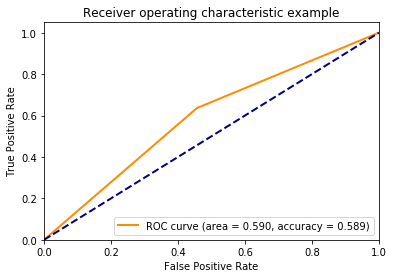

,Feature,Gain
134,points_7_diff,0.024656
120,points_5_diff,0.021069
62,outcome_7,0.018697
140,h_a,0.015617
77,outcome_o_7,0.015444
128,defensive_rebounds_7_diff,0.010169
117,blocks_5_diff,0.008791
50,made_three_point_field_goals_o_5,0.008788
93,made_field_goals_3_diff,0.008460
17,made_field_goals_o_3,0.008146


In [396]:
##Check Results and Feature Importance
testing_df = get_testing_df(X_test,y_test, nba_xgb_model)

fpr, tpr, _ = roc_curve(testing_df['preds'],testing_df['actuals'])
roc_auc = roc_auc_score(testing_df['preds'],testing_df['actuals'])
accuracy = accuracy_score(testing_df['preds'],testing_df['actuals'])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f, accuracy = %0.3f)' %(roc_auc,accuracy))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
#0.56

#Top 10 Features
feature_imp_df = get_feature_imp_df(tbs_grouped_full_df,nba_xgb_model)
feature_imp_df[0:10]

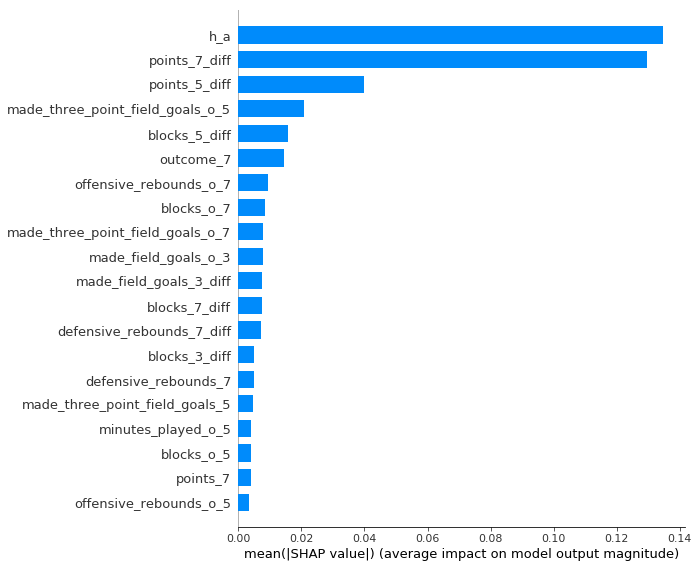

In [397]:
# explain the model's predictions using SHAP
shap_values, X_df = get_shap_imp_df(tbs_grouped_full_df,X_train,nba_xgb_model)
shap.summary_plot(shap_values, X_df, plot_type="bar")